# 1. Path to the files

In [1]:
# library
import os

# import os
path = os.getcwd()

# path to the smoothed time series
path_processed_table = path+"/00_database/03_smoothed/table.csv"

# path with satellite time series file
path_aux = path+"/00_database/01_input/sat.csv"

# path to save the ml model
path_out_ml = path+"/00_database/04_ml_models/"

# path to save the figure
path_out_fig = path+"/01_Figures/"

# 2. Input

In [2]:
# species to predict
target = "D. acuminata"

# all data range
year_0 = 2006
year_n = 2019

# years to test
year_test = [2014, 2015, 2016, 2017, 2018, 2019]

# year range of training
year_train_0 = 2006
year_train_n = 2013

# lead days to predict
lead_days_list = [7, 14, 21, 28]

# window (in days) to average value for prediction
winow_avg = 14

# lists of the three different prediction approaches used
predictors = {}
predictors["Auto-regressive prediction"] = ["cell_raw"]
predictors["Environmental prediction"] = ["sst", "northward_wind", "par", "eastward_wind"]
predictors["Combined prediction"] = ["cell_raw","sst", "northward_wind", "par", "eastward_wind"]

# 3. Read data

In [3]:
# library
import pandas as pd
import numpy as np

# Smoothed data
df = pd.read_csv(path_processed_table,
                 index_col=0)
df.index = pd.to_datetime(df.index)
df = df[(df.index.year>=year_0) & (df.index.year<=year_n)]
df_smoothed = df[["Smoothed "+target]]
df_smoothed[df_smoothed<0] = 0
df_smoothed = np.log(df_smoothed+1)

# Raw biomass data  
df_raw = df[[target]]
df_raw.columns = ["cell_raw"]
df_raw = np.log(df_raw+1)

# Satellite data
df_aux = pd.read_csv(path_aux, index_col=0)
df_aux.index = pd.to_datetime(df_aux.index)
df_aux = df_aux[(df_aux.index.year>=year_0) & (df_aux.index.year<=year_n)]

# Concat all
df_all = df_smoothed.join(df_raw).join(df_aux)

/tmp/ipykernel_19588/2044014772.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_smoothed[df_smoothed<0] = 0
/home/edsilv/anaconda3/envs/hab/lib/python3.9/site-packages/pandas/core/frame.py:3713: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


# 4. Cross-validation for tuning the number of components and SVM hyperparameters

In [4]:
# library
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# start tunning
params_dict = {}
for approach in predictors.keys():
    print(approach)
    
    for lead_day in lead_days_list:
        print(lead_day)
                    
        # subset predictors df
        df_predictors = df_all[predictors[approach]].rolling(winow_avg, min_periods=1).mean()
        
        # shift steps
        shift_list = [lead_day, lead_day+14, lead_day+28]
        for shift in shift_list:
            df_shift_id = df_predictors.shift(shift)
            df_shift_id.columns = [x+"_"+str(shift) for x in df_shift_id.columns]
            
            if shift == shift_list[0]:
                df_shift = df_shift_id
                
            else:
                df_shift = df_shift.join(df_shift_id)
        
        # subset to train and test
        df_subseted = df_all[["Smoothed "+target]].join(df_shift).dropna()
        df_subseted = df_subseted[(df_subseted.index.year>=year_train_0) & (df_subseted.index.year<=year_train_n)]
        index_ref = df_all["cell_raw"].dropna().index.intersection(df_subseted.index)
        df_subseted = df_subseted.loc[index_ref, :]
        
        # separate predictors of target
        X = df_subseted.iloc[:, 1:]
        y = df_subseted.iloc[:, 0]
        
        # create index for time cross validation
        index = X.index.year.values
        train_idx1 = np.where(index <= 2009)
        train_idx2 = np.where(index <= 2010)
        train_idx3 = np.where(index <= 2012)
 
        test_idx1 = np.where(index == 2010)
        test_idx2 = np.where(index == 2012)
        test_idx3 = np.where(index == 2013)
        
        cv = np.array([(train_idx1, test_idx1),
              (train_idx2, test_idx2),
              (train_idx3, test_idx3)], dtype=object).reshape((3,2))
        
        # configure pipeline param to explore in grid search
        n_components = len(X.columns)
        param_grid = {
        "pca__n_components": list(range(1, n_components+1)),
        "SVR__C": [0.1, 1, 10, 100],
        "SVR__kernel": ["linear"],
        "SVR__epsilon": [0.1, 1, 10]}
        
        pca = PCA()
        scaler = MinMaxScaler((-1, 1))
        svr_model = SVR()
        pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("SVR", svr_model)])
        
        # fit the pipiline and search for the best parameters
        search = GridSearchCV(pipe, param_grid, n_jobs=6, cv=cv,
                           scoring="r2")
        search.fit(X, y)
        params_dict[approach, lead_day] = search.best_params_

Auto-regressive prediction
7
14
21
28
Environmental prediction
7
14
21
28
Combined prediction
7
14
21
28


# 5. Testing the Forecast models

In [5]:
# library
from sklearn.inspection import permutation_importance
import pickle

# dictionary for saving results
pred_dict = {}
fi_dict = {}
ml_dict = {}
for approach in predictors.keys():
    print(approach)
    
    for lead_day in lead_days_list:
        print(lead_day)
                    
        # subset predictors df
        df_predictors = df_all[predictors[approach]].rolling(winow_avg, min_periods=1).mean()
        
        # shift steps
        shift_list = [lead_day,
                      lead_day+14,
                      lead_day+28]
        for shift in shift_list:
            df_shift_id = df_predictors.shift(shift)
            df_shift_id.columns = [x+"_"+str(shift) for x in df_shift_id.columns]
            
            if shift == shift_list[0]:
                df_shift = df_shift_id
                
            else:
                df_shift = df_shift.join(df_shift_id)
        
        # subset to train and test
        df_subseted = df_all[["Smoothed "+target]].join(df_shift).dropna()
        index_ref = df_all["cell_raw"].dropna().index.intersection(df_subseted.index)
        df_subseted = df_subseted.loc[index_ref, :]
        
        for year_t in year_test:
            
            #set model parameters
            params = params_dict[approach, lead_day]
            C = params["SVR__C"]
            epsilon = params["SVR__epsilon"]
            kernel = params["SVR__kernel"]
            n_pc = params["pca__n_components"]
            
            scaler = MinMaxScaler((-1, 1))
            pca = PCA(n_components=n_pc)
            svr_model = SVR(C=C,
                            epsilon=epsilon,
                            kernel=kernel)
            
            # train and test split
            df_train = df_subseted[[x < year_t for x in df_subseted.index.year]]
            df_train_X = df_train.iloc[:,1:]
            df_train_y = df_train.loc[:, "Smoothed "+target]
            
            # model fit
            ml = Pipeline(steps=[("scaler", scaler),
                                 ("pca", pca),
                                 ("SVR", svr_model)])
            ml.fit(df_train_X.values,
                   df_train_y.values.ravel())
            
            # predict the test data
            df_test = df_subseted[[x == year_t for x in df_subseted.index.year]]
            df_test_X = df_test.iloc[:,1:]
            df_test_y = df_test.loc[:, "Smoothed "+target]
            
            y_target_pred = ml.predict(df_test_X.values)
            df_pred_y = pd.DataFrame(y_target_pred,
                                   index=df_test_X.index,
                                   columns=["Predicted"])
            df_pred_y[df_pred_y<0] = 0
            
            # create prediction df
            if year_t==year_test[0]:
                df_pred = df_pred_y
                
            else:
                df_pred = df_pred.append(df_pred_y)
                
            
            # permutation for feature importance (only for combined aproach)
            if approach == "Combined prediction":
                fi_y = permutation_importance(ml,
                                            df_test_X,
                                            df_test_y,
                                            n_repeats=100,
                                            scoring="r2",
                                            n_jobs=-1)
                fi_y = pd.DataFrame(fi_y.importances_mean,
                                  index=df_test_X.columns)
                fi_y. columns = ["fi"]
                fi_y["year"] = year_t
                
                if year_t==year_test[0]:
                    fi_df = fi_y
                else:
                    fi_df = fi_df.append(fi_y)
                
            
        
            
        # save the prediction df in a dictionary
        pred_dict[approach, lead_day] = df_pred
        
        # save the fi in a dictionary
        if approach == "Combined prediction":
            fi_dict[approach, lead_day] = fi_df
            
        # save ml to dictionary
        ml_dict[approach, lead_day] = ml
            
# save last ml calibrated
with open(path_out_ml+"ml.pickle", 'wb') as handle:
    pickle.dump(ml_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

Auto-regressive prediction
7
14
21
28
Environmental prediction
7
14
21
28
Combined prediction
7
14
21
28


# 6. Create naive forecasts (persistence and climatology)

In [6]:
# climatology forecast
for year_t in year_test:
    idx_topredict = df_all[df_all.index.year==year_t].index
    idx_toestimateclim = df_all[df_all.index.year<year_t].index
    
    subset = df_all.loc[idx_toestimateclim][["Smoothed "+target]]
    subset["doy"] = subset.index.day_of_year
    subset = subset.groupby("doy").mean()
    df_clim_y = subset.loc[idx_topredict.day_of_year,:]
    df_clim_y.columns = ["Climatology"]
    df_clim_y.index = idx_topredict
    
    if year_t == year_test[0]:
        df_clim = df_clim_y
        
    else:
        df_clim = df_clim.append(df_clim_y)

In [7]:
# persistence forecast
subset = df_per_lead = df_raw.rolling(winow_avg,
                                         min_periods=1).max() # change max?
for lead_day in lead_days_list:

    df_per_lead = subset.shift(lead_day)
    df_per_lead.columns = [lead_day]
    
    if lead_day == lead_days_list[0]:
        df_per = df_per_lead
        
    else:
        df_per = df_per.join(df_per_lead)
        
df_per = df_per.dropna()

# 7. Compute statistics

In [8]:
# define a common index, so all forecast are evaluated using the same samples reference
idx = df_smoothed.index

# forecast models
for f_model in pred_dict.keys():
    idx_i = pred_dict[f_model].index
    idx = idx.intersection(idx_i)

# climatology
idx_i = df_clim.index
idx = idx.intersection(idx_i)

# persistence
idx_i = df_per.index
idx = idx.intersection(idx_i)

## 7.1 Forecast models R2 and MAE

In [9]:
# library
from sklearn.metrics import r2_score, mean_absolute_error, recall_score, precision_score, confusion_matrix, classification_report

# compute r and mae
dict_mae_predicted = {}
dict_r_predicted = {}
x = df_smoothed.loc[idx]
for f_model in pred_dict.keys():
    y = pred_dict[f_model].loc[idx]

    r = np.round(r2_score(x, y), 2)
    mae = np.round(mean_absolute_error(x, y), 2)
    
    dict_r_predicted[f_model] = r
    dict_mae_predicted[f_model] = mae

In [10]:
ref_date = x.groupby(x.index.year).idxmax().values.ravel()
dict_mae_peak = {}
for f_model in pred_dict.keys():

    y = pred_dict[f_model].loc[ref_date]
    mae = np.round(mean_absolute_error(x.loc[ref_date], y), 2)
    dict_mae_peak[f_model] = mae


In [11]:
# compute TPR and FAR
x = df_smoothed.loc[idx]
x_100 = x>np.log(100+1)
x_100 = x_100.astype(int)
dict_truepositive_100 = {}
dict_falsealarm_100 = {}

for f_model in pred_dict.keys():
    y = pred_dict[f_model].loc[idx]
    y_100 = y>np.log(100+1)
    y_100 = y_100.astype(int)

    tp_100 = tp = np.round(recall_score(x_100, y_100), 2)
    cm = confusion_matrix(x_100, y_100)
    fa_100 = np.round(1-precision_score(x_100, y_100), 2)

    dict_truepositive_100[f_model]  = tp_100
    dict_falsealarm_100[f_model] = fa_100
 
    

## 7.2 Climatological and persistence forecasts MAE

In [12]:
dict_mae_per = {}
x = df_smoothed.loc[idx]

# climatology
y = df_clim.loc[idx]
mae_clim = np.round(mean_absolute_error(x, y), 2)
    
# persistence
for lead_day in df_per.columns:
    y = df_per.loc[idx, lead_day]

    mae = np.round(mean_absolute_error(x, y), 2)
    dict_mae_per[lead_day] = mae

## 7.3 Forecast models SSc and SSp

In [13]:
dict_ssp = {}
dict_ssc = {}
for key in pred_dict.keys():
    
    ssc = 1 - (dict_mae_predicted[key]/mae_clim)
    ssp = 1 - (dict_mae_predicted[key]/dict_mae_per[key[1]])
    dict_ssc[key] = np.round(ssc, 2)
    dict_ssp[key] = np.round(ssp, 2)


## 7.4 Create a table with all results

In [14]:
df_r = pd.DataFrame(dict_r_predicted.values(),
                    index=dict_r_predicted.keys()).T
df_r.index = ["R2"]
df_mae = pd.DataFrame(dict_mae_predicted.values(),
                      index=dict_mae_predicted.keys()).T
df_mae.index = ["MAE"]

df_peakmae = pd.DataFrame(dict_mae_peak.values(),
                      index=dict_mae_peak.keys()).T
df_peakmae.index = ["MAEpeak"]

df_ssp = pd.DataFrame(dict_ssp.values(),
                      index=dict_ssp.keys()).T
df_ssp.index = ["SSp"]
df_ssc = pd.DataFrame(dict_ssc.values(),
                      index=dict_ssc.keys()).T
df_ssc.index = ["SSc"]

df_tp100 = pd.DataFrame(dict_truepositive_100.values(),
                      index=dict_truepositive_100.keys()).T
df_tp100.index = ["TP_100"]

df_fa100 = pd.DataFrame(dict_falsealarm_100.values(),
                      index=dict_falsealarm_100.keys()).T
df_fa100.index = ["fa_100"]


df_stats = df_r.append(df_mae).append(df_peakmae).append(df_ssp).append(
    df_ssc).append(df_tp100).append(df_fa100)

In [15]:
df_stats

Auto-regressive prediction                   Environmental prediction  \
                                7     14    21    28                       7    
R2                            0.30  0.14  0.01 -0.12                     0.40   
MAE                           1.43  1.59  1.71  1.83                     1.31   
MAEpeak                       1.20  1.52  2.01  2.85                     0.99   
SSp                           0.29  0.24  0.23  0.27                     0.35   
SSc                          -0.01 -0.12 -0.20 -0.29                     0.08   
TP_100                        0.39  0.32  0.34  0.29                     0.54   
fa_100                        0.00  0.07  0.07  0.14                     0.35   

                          Combined prediction                    
           14    21    28                  7     14    21    28  
R2       0.50  0.38  0.37                0.55  0.49  0.46  0.47  
MAE      1.19  1.31  1.35                1.13  1.25  1.26  1.23  
MAEpeak  1.02  1.15  1.34                0.62  0.86  0.87  1.19  
SSp      0.43  0.41  0.46                0.44  0.40  0.43  0.51  
SSc      0.16  0.08  0.05                0.20  0.12  0.11  0.13  
TP_100   0.51  0.54  0.46                0.56  0.44  0.54  0.44  
fa_100   0.30  0.35  0.39                0.04  0.18  0.21  0.31

# 8. Plot time series validation

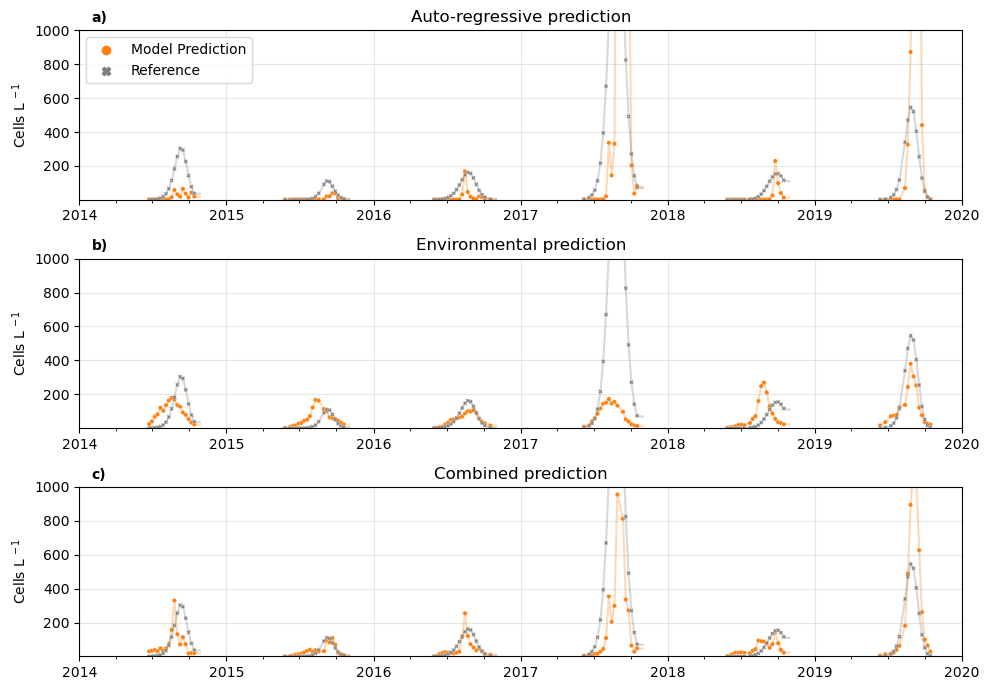

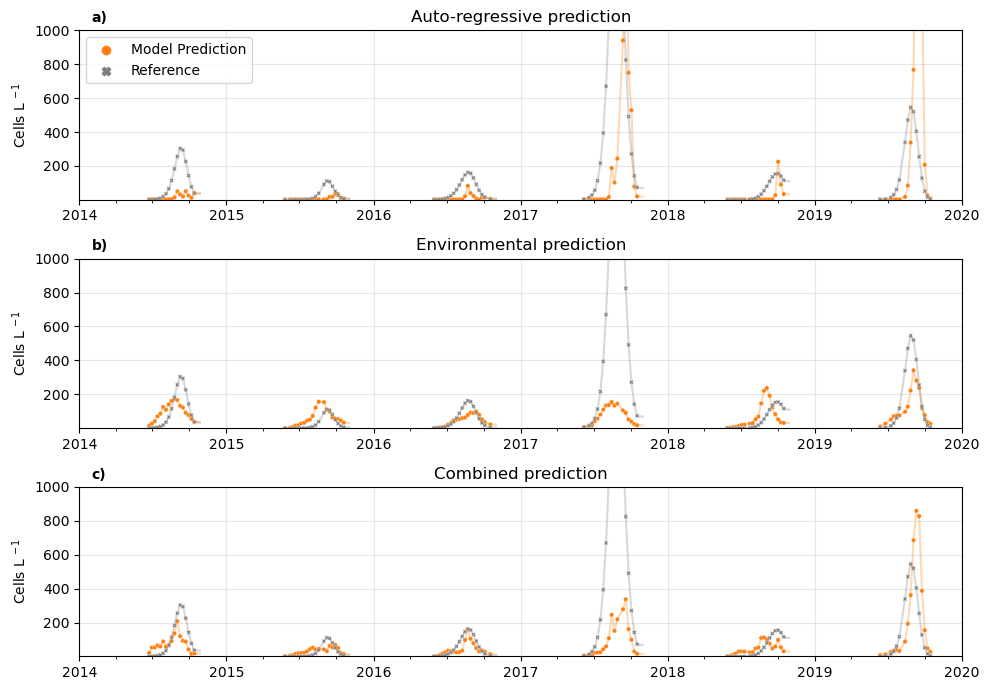

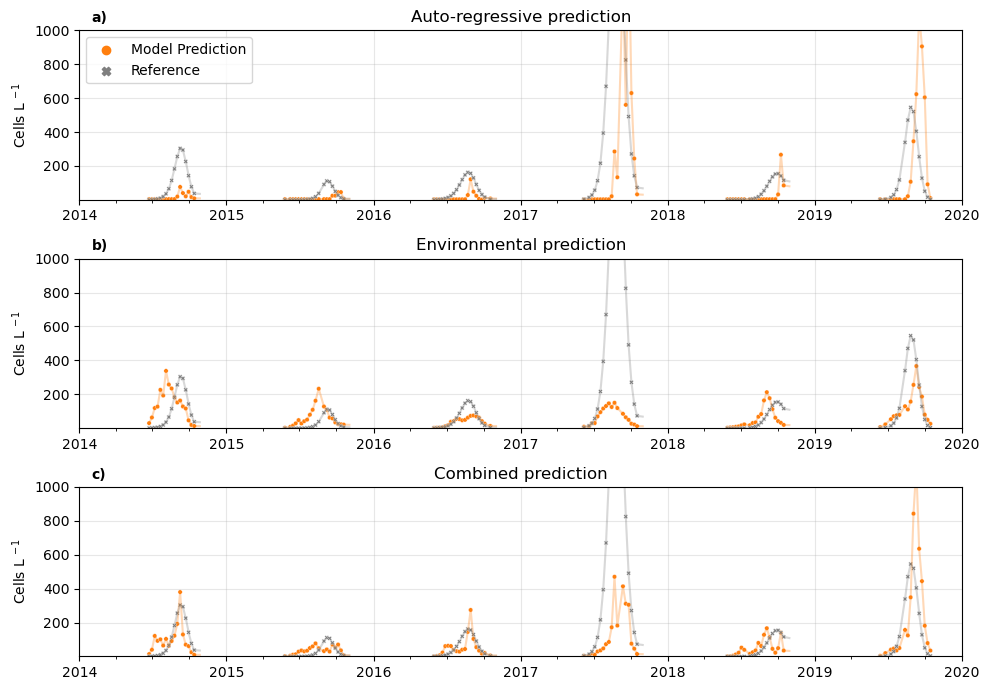

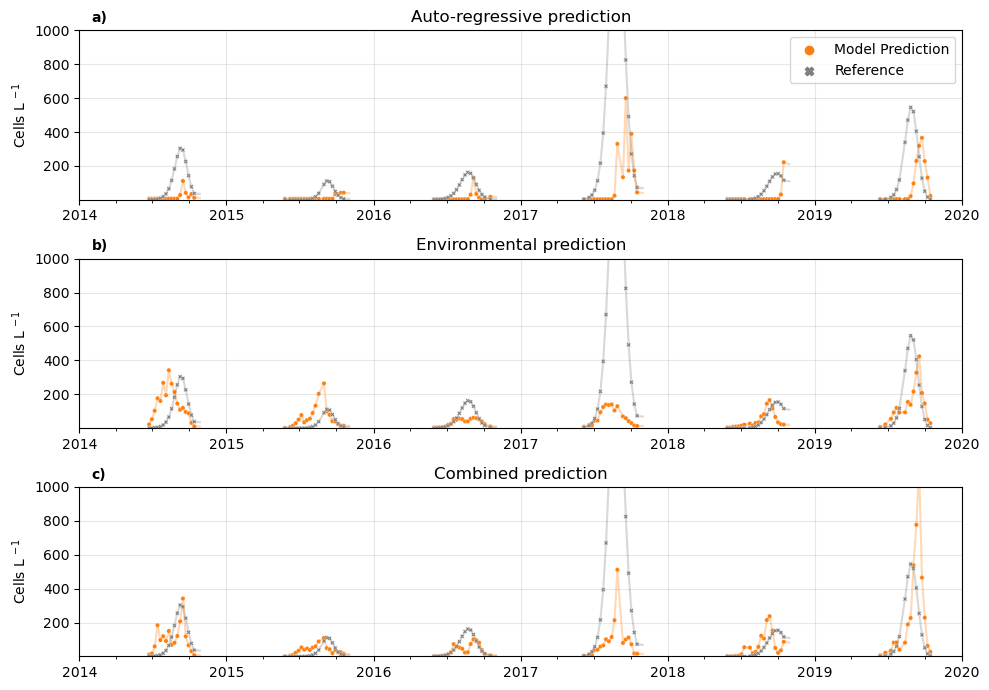

In [16]:
# library
import matplotlib.pyplot as plt
import copy as cp
import seaborn as sns
import datetime as dt
import string

# start plot
reference = x
reference.columns = ["Reference"]

for week in [7, 14, 21, 28]:
    
    fig = plt.figure(figsize=(10, 7))
    i = 1

    for approach in predictors.keys():

        if approach == "Auto-regressive prediction":
            leg=True

        else:
            leg=False

        subset = cp.copy(pred_dict[(approach, week)]).loc[idx, ["Predicted"]]
        subset.columns = ["Model Prediction"]
        subset = subset.join(reference)
        subset = np.exp(subset)-1
        ax = plt.subplot(3, 1, i)
        sns.scatterplot(data=subset,
                        ax=ax,
                        legend=leg,
                        s=10,
                        palette=["tab:orange", "tab:gray"])

        subset.resample("1d").first().interpolate(limit=14,
                                                  limit_area="inside").plot(ax=ax,
                                                                            legend=False,
                                                                            color=["tab:orange", "tab:gray"],
                                                                            alpha=0.3)

        #ax.set_ylim((-0.1, 10))

        ax.set_title(approach)
        ax.set_ylabel("Cells L $^{-1}$")
        ax.set_xlabel("")
        ax.set_xlim([dt.date(2014, 1, 1), dt.date(2020, 1, 1)])
        ax.text("2014-02-01",
                1050,
                string.ascii_lowercase[i-1]+")",
                fontsize="medium",
                fontweight='bold')
        ax.set_ylim((0, 1000))
        ax.grid(alpha=0.3)
        ax.set_ylim((1,1000))
        i = i+1

    plt.tight_layout()
    
    fig.savefig(path_out_fig+"validation_ts_"+str(week)+".png", dpi=300)


# 9. Plot feature importance

/tmp/ipykernel_19588/330890188.py:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(ax=ax,
/tmp/ipykernel_19588/330890188.py:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(ax=ax,
/tmp/ipykernel_19588/330890188.py:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(ax=ax,
/tmp/ipykernel_19588/330890188.py:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(ax=ax,


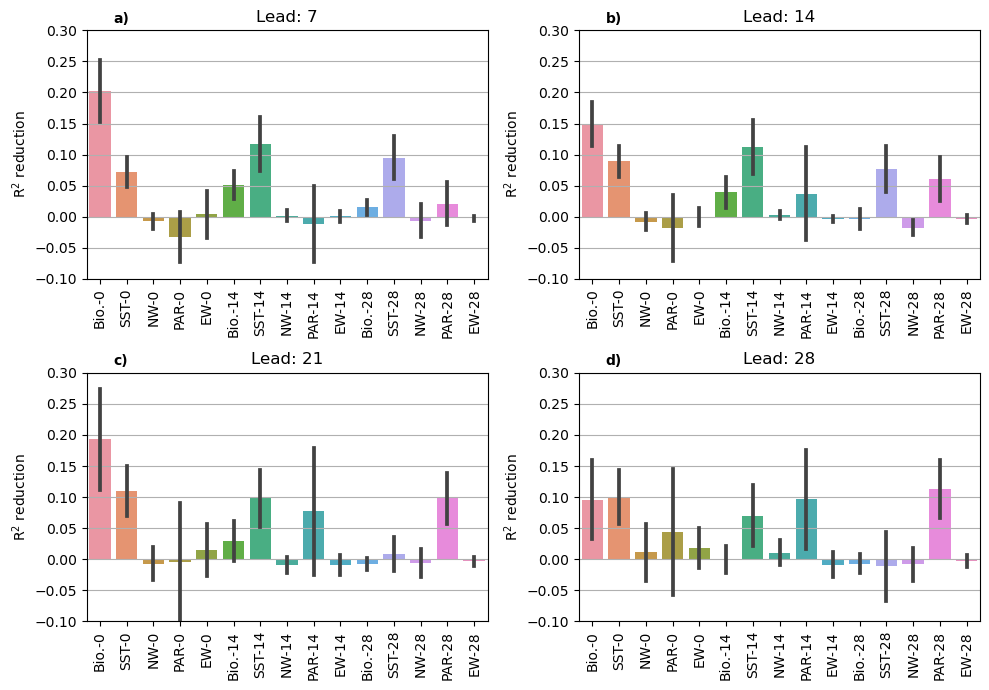

In [17]:
fig = plt.figure(figsize=(10,7))
i = 1
for key_i in fi_dict.keys():
    # subset
    df_sens = cp.copy(fi_dict[key_i])
    
    lead = key_i[1]
    new_index_step = [int(x.split("_")[-1])-lead for x in df_sens.index]
    new_index_name = [x.split("_")[0] for x in df_sens.index]
    new_index_name = [x.replace("cell", "Bio.").
                      replace("sst", "SST").
                      replace("par", "PAR").
                      replace("northward", "NW").
                      replace("eastward", "EW") for x in new_index_name]
    new_index = [x +"-"+str(y) for x,y in zip(new_index_name, new_index_step)]
    df_sens.index = new_index
    df_sens["Variable"] = df_sens.index
    ax = plt.subplot(2, 2, i)
    
    sns.barplot(ax=ax,
                data=df_sens,
                x="Variable",
                y="fi",
                ci="sd")
    
    ax.tick_params(axis="x",
                   rotation=90)
    ax.grid(axis="y")
    ax.set_ylim((-0.1, 0.30))
    ax.set_title("Lead: "+str(lead))
    ax.set_xlabel("")
    ax.set_ylabel("R$^{2}$ reduction")
    ax.text(0.5,
            ((ax.get_ybound()[1]-ax.get_ybound()[0])*1.03)+ax.get_ybound()[0],
            string.ascii_lowercase[i-1]+")",
            fontsize="medium",
            fontweight='bold')
    
    i = i+1
  #  """        
plt.tight_layout()
fig.savefig(path_out_fig+"feature_importance.png", dpi=300)